<center><h1>ECSE 443: Introduction to Numerical Analysis in Electrical Engineering</h1></center>
<center><h3>Assignment 4: Fourier analysis</h3></center>
<center><h3>Due: May 1<sup>st</sup>, 2020 at 11:59pm EST on [myCourses](https://mycourses2.mcgill.ca/)</h3></center>
<center><h3>Final weight: <i>17.5%</i></h3></center>

<u style="font-size:16pt;">Assignment submission process</u>

Download and modify the `ipynb` notebook we provide on myCourses and submit your modified file, renamed according to your student ID, as

<center><font color='red'>`[YourStudentID]`.ipynb</font></center>

For example, if your id is **234567890**, your submission filename should be **234567890.ipynb**.


<div class="alert alert-note" role="alert">
      Every time you submit a new file, your previous submission will be overwritten. You can submit as many times as you like, but we will only grade the last submission. **We will only accept submissions made through myCourses -- please do not e-mail us your assignment**
</div>

<u style="font-size:16pt;">Late policy & Python `import` statements</u>

This assignment is to be completed individually. 

<div class="alert alert-danger" role="alert">
     Late Policy: non-negotiable time-based penalty - 
    You will lose **5% per hour long period** past the deadline.
</div>

We provide all import statements required to complete the assignment.

<div class="alert alert-danger" role="alert">
    `import` Policy: do not use any `import`s other than those we provide.
    Doing so will result in a score of **zero (0%)** on the assignment.
</div>

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to load the necessary libraries.  
</div>

In [1]:
from __future__ import print_function
import sys
import threading

from numpy import float32, uint8, ceil
from numpy import array, zeros, arange, pad, concatenate, linspace
from numpy import sin, cos, pi, absolute, angle, outer, dot, min, max, log, log2, real, imag, std, sum, sqrt, exp, clip
from numpy import logical_or
from numpy import allclose, load
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from IPython.display import Audio
import random
from PIL import Image

try:
    import thread
except ImportError:
    import _thread as thread
try:
    range, _print = xrange, print
    def print(*args, **kwargs):
        flush = kwargs.pop('flush', False)
        _print(*args, **kwargs)
        if flush:
            kwargs.get('file', sys.stdout).flush()
except NameError:
    pass

def quit_function(fn_name):
    # print to stderr, unbuffered in Python 2.
    print('{0} took too long'.format(fn_name), file=sys.stderr)
    sys.stderr.flush() # Python 3 stderr is likely buffered.
    thread.interrupt_main() # raises KeyboardInterrupt

def exit_after(s):
    def outer(fn):
        def inner(*args, **kwargs):
            timer = threading.Timer(s, quit_function, args=[fn.__name__])
            timer.start()
            try:
                result = fn(*args, **kwargs)
            finally:
                timer.cancel()
            return result
        return inner
    return outer

def loadImage(path, scale):
    image = Image.open(path, mode = 'r')
    image = image.resize((int(image.width * scale / 100), int(image.height * scale / 100)), resample=Image.LANCZOS)
    image = array(image.getdata()).reshape(image.size[1], image.size[0], 3)
    image = image.astype(float)
    image = image / max(image)
    
    return image

def uintImage(image):
    image = clip(image, 0, 1)
    imMax = max(image)
    if imMax < 1e-5:
        imMax = 1
    image = image / imMax * 255
    return image.astype(uint8)

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Discrete Fourier Transform **[10 points]**

Given an input function $f$ sampled at $N$ equally-spaced discrete points $x \in \{0, \ldots, N-1\}$ in the primal domain (e.g., time), we denote this discretized signal as $f(x) \equiv f[x]$. Note that, in general, $f$ can be a _complex-valued_ function (and, so too the sampled values $f[\cdot]$); however, our examples will only consider real-valued input functions.

The __discrete Fourier transform__ (DFT) $\overline{f}[x]$ of the signal is then given by:

$$
\overline{f}[x] = \sum\limits_{k=0}^{N-1} f[k] \exp{\left(\frac{-2\pi \imath k x}{N}\right)},
$$

which can be equivalently expressed as a matrix-vector operation (see lecture slides) as

$$
\mathbf{\overline{f}} = \mathbf{M}_N\, \mathbf{f}~,
$$

where $\mathbf{f} = (f[0], f[1], \ldots, f[N-1])$ is a vector of all the sampled function values, $\mathbf{M}_N$ encodes the linear operator form of the DFT for a length-$N$ input, and $\mathbf{\overline{f}} = (\overline{f}[0], \overline{f}[1], \ldots, \overline{f}[N-1])$ is a vector of the sampled DFT of $f$.

The (discrete) signal $\overline{f}[x]$ can be interpreted as a discrete sampling of the continuous Fourier transform $\mathcal{F}\{f_N(x)\}$ of an $N$-periodic summation of $f(x)$ -- i.e., $f(x)$ repeated periodically.

Note that, regardless of whether the input signal is real- or complex-valued, the DFT $\overline{f}[x]$ **always** has complex-valued elements: $\operatorname{Re}(\overline{f})$ encodes the frequency amplitudes and $\operatorname{Im}(\overline{f})$ their phases.

The __inverse discrete Fourier transform__ (iDFT) allows us to transform back, from this (discrete, complex-valued) frequency spectrum to the original (possibly only real-valued) sampled signal in the primal domain, as

$$
f[x] = \frac{1}{N}\sum\limits_{k=0}^{N-1} \overline{f}[k] \exp{\left(\frac{2\pi \imath k x}{N}\right)}.
$$

Note the similarities in the mathematical definitions of the DFT and iDFT, comprising of a sign change in the complex exponential and differing normalization constants. You will leverage these similarities to avoid code duplication: your implementation of the iDFT will rely on an implementation of a _generalized_ DFT.

Specifically, you will implement this generalized DFT formula for a sampled input $\Upsilon[\cdot]$, 

$$
\Psi[x;\mbox{s}] = \sum\limits_{k=0}^{N-1} \Upsilon[k] \exp{\left(\mbox{s}\frac{2 \pi \imath k x}{N}\right)},
$$

where we obtain the DFT by setting $\Upsilon = f$ and $s = -1$, and the iDFT with $\Upsilon = \tfrac{1}{N} \overline{f}$ and $s = 1$.

Your implementations will act on, and return, an **entire vector** of values corresponding to either the DFT or iDFT.

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[7.5 Points]</b> Implement the DFT function <i>DFT</i> as specified by $\Psi$ and with the default setting of $\mbox{s} = -1$. 
</div>

<!--
<div class="alert alert-danger" role="alert">
Note that the function <i>dft</i> serves as the reference for all other tests. You <b>must</b> implement the function correctly. 
</div>
-->

In [2]:
# x - real-valued scalar input
# returns the complex exponential computed using Euler's formula
def complexExp(x : float32):
    arg = 2 * pi * x 
    return cos(arg) + 1j * sin(arg)

In [3]:
# inSignal - (possibly complex-valued) 1D input signal array
# s - sign parameter with default value -1 for the DFT setting
# returns the DFT of the input signal
def DFT(inSignal : complex, s : int = -1): 
    y = zeros(inSignal.shape, dtype=complex)
    # Hint 0: Use the complexExp function
    # YOUR CODE HERE
    N = inSignal.shape[0]
    for k in range (N):
        for i in range (N):
            y[i] += (inSignal[k]*complexExp(s*k*i/N))
    return y

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[2.5 Points]</b> Implement the iDFT function <i>iDFT</i> using the <i>DFT</i> function.
</div>

In [4]:
# inSignal - complex-valued 1D DFT input array
# returns the iDFT of the input signal
def iDFT(inSignal : complex):
    y = zeros(inSignal.shape, dtype=complex)
    
    # Hint 0: Use the complexExp function
    # YOUR CODE HERE
    N= inSignal.shape[0]
    y = DFT(inSignal/N, 1)
    
    return y

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to test your implementation of <i>DFT</i> and <i>iDFT</i>.
</div>

In [5]:
def testDFT():
    N = 16
    r = rand(2*N)
    complexNums = array([complex(r[i], r[i+N]) for i in range(N)])
    
    ret1 = DFT(iDFT(complexNums))
    ret2 = iDFT(DFT(complexNums))
       
    l0 = load("Data/t1.npz")

    return allclose(DFT(l0['cN'], -1), l0['dF1']) and allclose(DFT(l0['cN'], 1), l0['df2']) and allclose(ret1, complexNums) and allclose(ret2, complexNums) 
    
try:
    assert(testDFT())
    print('Congratulations - DFT implementation is correct')
except:
    raise Exception("One or both of your DFT and/or iDFT implementations is faulty. Please revise and try again.")   

Congratulations - DFT implementation is correct


# Fast Fourier Transform (FFT)**[30 points]**

For a length-$N$ discrete input signal, the naive DFT implementation above requires $\mathbf{O}(N^2)$ time. This becomes prohibitively costly for large $N$.

You will implement an FFT algorithm for fast DFTs, use it to similarly implement a fast iDFT, and then benchmark your FFT's performance against your earlier naive DFT implementation.

As with the DFT and iDFT implementations above, your `FFT` implementation will have a `s`ign parameter that you will use when you rely on `FFT` to implement the iDFT implementation (`iFFT`), later on.


## The Cooley-Tukey FFT Algorithm

The Cooley-Tukey Fast Fourier Transform (FFT) algorithm applies a hierarchical and recursive strategy to accelerate the computation of the DFT (and, so too, the iDFT). Its running time is $\mathbf{O}(N \log N)$. Since the FFT operates recursively over power-of-2 reductions in the input signal, the input signal must have a power-of-2 length. If not, in practice you can pad your input with zeros until it reaches the next power-of-2 length.

The derivation of this FFT algorithm requires us to first notice an important property of the DFT $\mathbf{\overline{f}}$ of a sampled input signal $\mathbf{f}$: by considering how the value of the complex exponential $\exp{({-2\pi \imath k x}/{N})}$ in the DFT equation changes if we index **past** the last ($(N-1)^{th}$) index, we note that $\overline{f}[a + b N] = \overline{f}[a]$. In other words, the sampled values of the DFT are periodic, if we extend the indexing past the $N$ values of the transform.

The FFT algorithm exploits this periodicity in order to accelerate computation, as follows: the DFT of a length-$N$ sampled signal $f$ can be computed from the DFT of two length-$(N/2)$ signals $f_e$ and $f_o$ composed of the _even_ and _odd_ indexed values of $f$, as

$$
\overline{f}[x] = \underbrace{\sum_{k=0}^{N/2 - 1} f_e[k] \exp{\left(\frac{-2\pi \imath k x}{(N/2)}\right)}}_{\overline{f_e}[x]} + \exp{\left(\frac{-2\pi \imath x}{N}\right)} \underbrace{\sum_{k=0}^{N/2 - 1} f_o[k] \exp{\left(\frac{-2\pi \imath k x}{(N/2)}\right)}}_{\overline{f_o}[x]}~.
$$

In matrix-vector form, the benefits of this reformulation become clear, if we denote the DFT vector of the even- and odd-indexed samples as $\mathbf{f}_e = (f_e[0], f_e[1], \ldots, f_e[N/2 - 1]) = (f[0], f[2], \ldots, f[N - 2])$ and $\mathbf{f}_o = (f_o[0], f_o[1], \ldots, f_o[N/2 - 1]) = (f[1], f[3], \ldots, f[N - 1])$,  

$$
\overline{\mathbf{f}} = \mathbf{M}_N \, \mathbf{f} = \begin{bmatrix}\mathbf{I}_{(N/2)\times(N/2)}&\mathbf{diag}(\mathbf{\widehat{e}_a})\\\mathbf{I}_{(N/2)\times(N/2)}&\mathbf{diag}(\mathbf{\widehat{e}_b})\end{bmatrix} \begin{bmatrix}\mathbf{M}_{N/2}&\mathbf{0}\\\mathbf{0}&\mathbf{M}_{N/2}\end{bmatrix} \begin{bmatrix}\mathbf{f}_{e}\\\mathbf{f}_o\end{bmatrix} = \begin{bmatrix}\mathbf{I}_{(N/2)\times(N/2)}&\mathbf{diag}(\mathbf{\widehat{e}_a})\\\mathbf{I}_{(N/2)\times(N/2)}&\mathbf{diag}(\mathbf{\widehat{e}_b})\end{bmatrix} \begin{bmatrix}\mathbf{\overline{f}}_{e}\\\mathbf{\overline{f}}_o\end{bmatrix}~,
$$

where $\mathbf{I}_{(N/2)\times(N/2)}$ is an $(N/2) \times (N/2)$ identity matrix, $\mathbf{diag}(\mathbf{y})$ is a diagonal matrix with diagonal entries denoted by the vector $\mathbf{y}$, and $\mathbf{\widehat{e}_a}$ and $\mathbf{\widehat{e}_b}$ combine to form the first and last $(N/2)$ evaluations of the length-$N$ vector $\mathbf{\widehat{e}} = (1, \omega, \omega^2, \ldots, \omega^{N-1})$ with $\omega = \exp(-2\pi\imath/N)$.


We can further leverage a symmetry in $\mathbf{\widehat{e}}$ to notice that $\mathbf{\widehat{e}_b} = -\mathbf{\widehat{e}_a}$, but the real performance gain here is that the original length-$N$ DFT matrix $\mathbf{M}_N$ can be factored into the product of a sparse matrix and a block-diagonal matrix. The latter simply encodes two smaller length-$(N/2)$ DFTs, and the periodicity of these DFTs is exploited in order to obtain the final length-$N$ output.

While applying this decomposition once would accelerate the computation of a length-$N$ DFT by roughly a factor of two, the Cooley-Tukey algorithm __recursively__ applies this decomposition until the problem is reduced to that of computing a very small DFT. In the limit, assuming that $N$ is a power-of-two (which we will assume), the base case of the recursion simply computes a length-1 DFT[^challenge]. We've exposed the `int`, `ceil` and `concatenate` functions from `numpy` to help, if you need them.

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[25 Points]</b> Implement the recursive FFT algorithm describe above, in the <i>FFT</i> function below.
</div>

In [6]:
# inSignal - (potentially complex-valued) 1D input signal array (power-of-2 length)
# s - sign parameter with default value -1 for the DFT setting
# returns the DFT of the signal computed using the FFT
def FFT(inSignal : complex, s : int = -1):
    N = inSignal.size
    output = zeros(N, dtype = complex)
    
    # Ensure that N has power-of-2 length
    try:
        assert((N & (N - 1) == 0) and N != 0)
    except:
        raise Exception("N is not a power-of-two!")
    
    # Recursively compute the FFT
    # Base case (see the note below on optionally modifying this case)
    if N == 1:
        return inSignal
    
    # YOUR CODE HERE
    Even = FFT(inSignal[::2])            
    Odd = FFT(inSignal[1::2])
    e = complexExp(s * arange(N) / N)
    output = concatenate([Even + e[:int(N/2)] * Odd, Even + e[int(N/2):] * Odd])
    return output

**[Challenge1]:** Technically speaking, the base case does not **have** to be the length-1 scenario; relying on the naive/brute-force DFT computation to perform the base case for a length $> 1$ is an interesting engineering axis to explore. Those who are interested can independently try to benchmark the performance of choosing different settings for the base case length.

<div class="alert alert-info" role="alert">
<b>Run</b> the following cells to test your implementation of <i>fft</i>.
</div>

In [7]:
@exit_after(1)
def testFFT():
    for p in range(2):
        r = rand(2**(6+p))
        N = r.size // 2
        complexNums = array([complex(r[i], r[i+N]) for i in range(N)])
            
        reference = DFT(complexNums, -1)
        fftSolution = FFT(complexNums, -1)
        
        if not allclose(reference, fftSolution):
            return False
    
    FFT(rand(2**12).astype(complex), 1)
    
    return True

try:
    assert(testFFT())
    print('Congratulations - FFT implementation is correct.')
except:
    raise Exception("Your implementation of the FFT is incorrect...try again.")

Congratulations - FFT implementation is correct.


Just as with the naive DFT implementation, you can implement the inverse DFT using the FFT routine you just implemented.

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[5 Points]</b> Implement a fast iDFT using your `FFT` implementation, above.
</div>

In [8]:
# inSignal - complex-valued 1D input signal array (power-of-2 length)
# returns the inverse DFT of the input signal
def iFFT(inSignal : complex):
    # YOUR CODE HERE
    N = inSignal.shape[0]
    tmp = FFT(inSignal)/N
    out = zeros(inSignal.shape, dtype = complex)
    for i in range (1,N):
        out[N - i] = tmp [i]
    out[0] = tmp[0]
    return out
    #raise NotImplementedError()

<div class="alert alert-info" role="alert">
<b>Run</b> the following cells to test your implementation of <i>iFFT</i>.
</div>

In [9]:
@exit_after(1)
def testiFFT():
    for p in range(2):
        r = rand(2**(6+p))
        N = r.size // 2
        complexNums = array([complex(r[i], r[i+N]) for i in range(N)])
            
        reference = DFT(complexNums, 1) / N
        fftSolution = iFFT(complexNums)
        
        if not allclose(reference, fftSolution):
            return False
    
    iFFT(rand(2**12).astype(complex))
    
    return True

try:
    assert(testiFFT())
    print('Congratulations - iFFT implementation is correct')
except:
    raise Exception("Your iFFT implementation is incorrect...try again.")

Congratulations - iFFT implementation is correct


Finally, we'll conduct a performance analysis to compare the running times of the naive and optimized DFT computations.

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to compare the performance of the naive DFT computation to your FFT implementation.
</div>

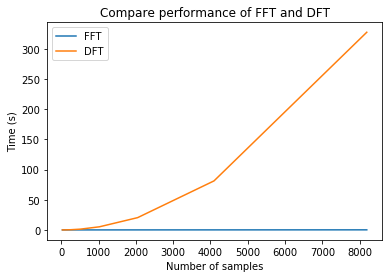

In [10]:
def measurePerformance():
    fft_time = []
    dft_time = []
    n = []
    for i in range(5, 14):
        complexNums = rand(2**i) + 1j * rand(2**i)
        f_time = %timeit -n 1 -r 1 -q -o FFT(complexNums)
        d_time = %timeit -n 1 -r 1 -q -o DFT(complexNums)
        
        n.append(2**i)
        fft_time.append(f_time.timings[0])
        dft_time.append(d_time.timings[0])
    
    plt.plot(n, fft_time, label='FFT')
    plt.plot(n, dft_time, label='DFT')
    plt.xlabel('Number of samples')
    plt.ylabel('Time (s)')
    plt.title('Compare performance of FFT and DFT')
    plt.legend()
    plt.show()

measurePerformance()

# Making Sense of the Frequency Domain **[15 points]**

We'll run an experiment to get comfortable tinkering with DFT frequency domain samples (computed using your FFT.) The cell below constructs a function composed of a simple mixture of sinusoids.

Here, the test signal comprises a DC/constant and three sinusoids, each with a magnitude, frequency/period and phase.

Another important point to note is that -- in this discrete setting -- we need to explicitly define the range of primal domain space (`T`) under which we'll be drawing our discrete samples, as well as the number of samples (`nsamps`) we'll draw. 

Keep in mind that the number of samples will limit the highest frequency we can capture without aliasing. We set `nsamps` high enough to capture the frequencies of our test signal, below.

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to construct and plot a simple test signal.
</div>


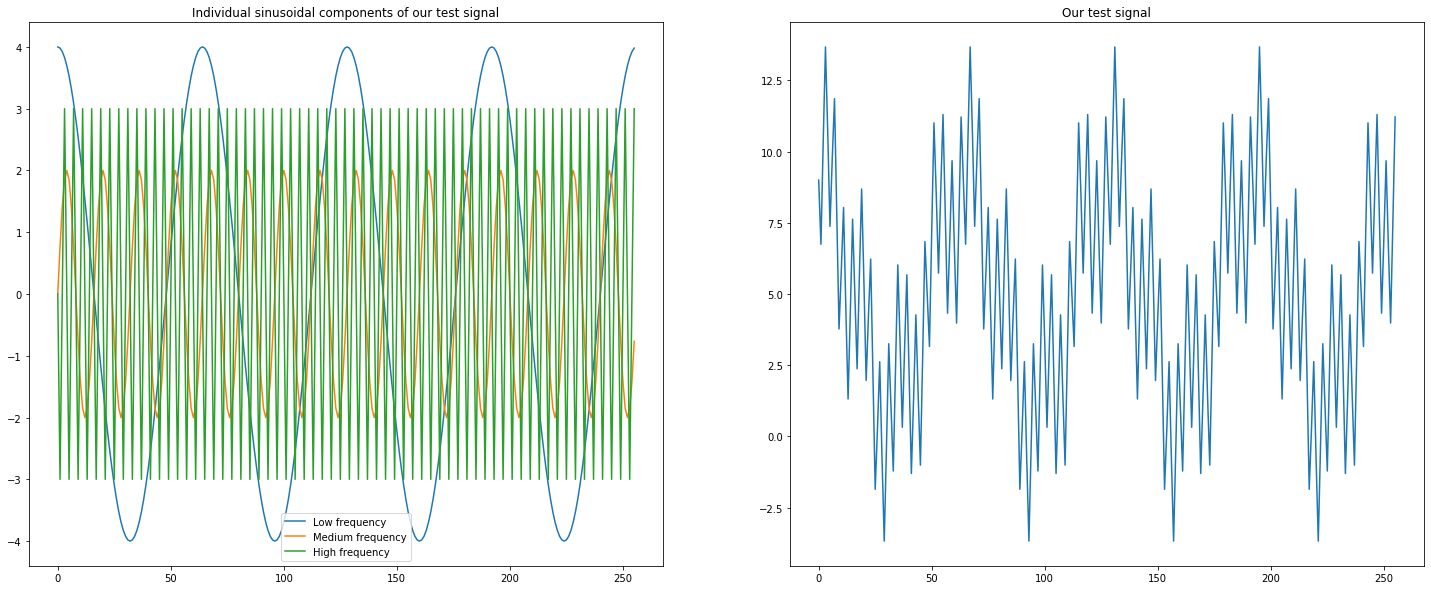

In [11]:
nsamps = 256 # must be power-of-2 for FFT

# let's take measurements between 0 and 2 seconds
# (really, any arbitrary unit of time)
T = 2.0
t = arange(0, T, T/nsamps ) # same as linspace(0,T,nsamps)

# define the parameters of our mixture of sinusoids test signal
DC, low, mid, high = [5, [4,2,0], [2,8,-pi/2], [3,32,pi/2]]
lowFreqSignal = low[0] * cos( 2 * pi * low[1] * t + low[2]) 
midFreqSignal = mid[0] * cos( 2 * pi * mid[1] * t  + mid[2]) 
highFreqSignal = high[0] * cos( 2 * pi * high[1] * t + high[2]) 

# the test signal
signal1D = DC + lowFreqSignal + midFreqSignal + highFreqSignal

# plot the individual components
f, axarr = plt.subplots(1, 2, figsize=(25,10))
axarr[0].plot(lowFreqSignal, label='Low frequency')
axarr[0].plot(midFreqSignal, label='Medium frequency')
axarr[0].plot(highFreqSignal, label='High frequency')
axarr[0].legend()
axarr[0].set_title("Individual sinusoidal components of our test signal")

# plot the final test signal
axarr[1].plot(signal1D)
axarr[1].set_title("Our test signal")

plt.show()

Let's compute the DFT (using `FFT`) for our test signal, and visualize its magnitude and phase using `numpy`'s `absolute` and `angle` functions.


<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to construct and plot a simple test signal.
</div>

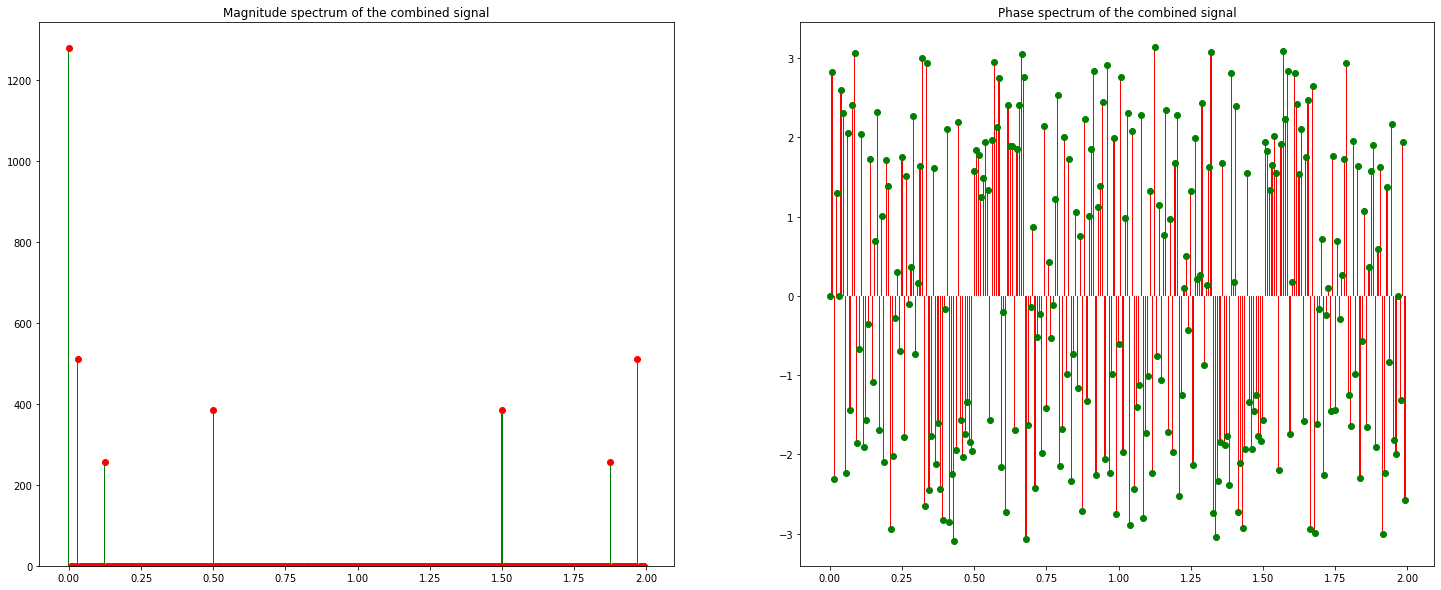

In [12]:
signal1DFFT = FFT(signal1D)
f, axarr = plt.subplots(1, 2, figsize=(25,10))
axarr[0].bar(t,absolute(signal1DFFT), width=1.0/len(t), color="green")
axarr[0].plot(t,absolute(signal1DFFT), "ro")
axarr[0].set_title("Magnitude spectrum of the combined signal")
axarr[1].bar(t,angle(signal1DFFT), width=1.0/len(t), color="red")
axarr[1].plot(t, angle(signal1DFFT), 'go')
axarr[1].set_title("Phase spectrum of the combined signal")
plt.show()

This is a good start, but we're far from getting a full grasp of what these plots are telling us in this toy example.

A few things to note in these plots:

<b style="color:green; font-size:18pt;">+</b>the magnitude plot exhibits expected symmetries, since we're taking the DFT of a _real-valued_ function;

<b style="color:green; font-size:18pt;">+</b>outside of the first magnitude peak (at index 0 of `absolute(signal1DFFT)`, corresponding to the DC offset), we see three distinct (symmetrically mirrored) peaks corresponding to the distinct sinusoidal frequencies in our signal;

<b style="color:red;">--</b> the scale (i.e., on the $y$-axis) is seemingly nonsensical;

<b style="color:green; font-size:18pt;">+</b>at a glance, the _relative_ scale of the three harmonic peaks look right, i.e., compared to their associated magnitudes....

<b style="color:red;">--</b> ... but not the relative scale of the DC peak;

<b style="color:red;">--</b> it's hard to tell (i.e., on the $x$-axis) whether the harmonic peak locations are correct, namely, that they correspond to the frequencies associated to each sinusoid;

<b style="color:red;">--</b> and, finally, the phase plot is gibberish!

Your next goal will be to adjust the data and plotting axes in order to make more sense of the DFT content, according to the guidelines, below:

1. in the magnitude plot, change the $x$-axis ticks to use frequency units instead of time units; do the three harmonics line up where you'd expect them to?
	- <u>hint</u>: this conversion from time to frequency will depend on `T` and `nsamps`. You can use `arange` or `linspace` to create the array of $x$-axis "ticks" to plot at.

2. in the magnitude plot, re-scale the data so that the magnitudes of the DC and harmonic terms match what you would expect them to be.
	- <u>hint #1</u>: you can arrive at the appropriate scaling factor for the DC term by looking at the definition of the DFT at $x = 0$ (i.e., $\overline{f}[0]$) and figuring out how to normalize the value to yield the average of the signal, and
	- <u>hint #2</u>: all the non-DC frequency components need to be scaled by _twice_ the scaling value of the DC component, due to the contributions of their symmetrically-mirrored elements (i.e., after index $N/2$ in the DFT; note that the DC term is not mirrored.)

3. in the phase plot, adjust the $x$-axis as you did in #1 above, but also clean up the data to expose discrete phases of the sinusoids in our test signal.
	- <u>hint</u>: due to numerical precision, some DFT elements have __near-zero__ magnitude values; adjust the magnitude and phase to 0 for these "effectively zero magnitude" indices.

<div class="alert alert-warning" role="alert">
 <b style="color:green;">&#9745;</b> <b>[15 Points]</b> Adjust and re-plot the magnitude and phase plots of our signal, as per the guidelines above.
</div>

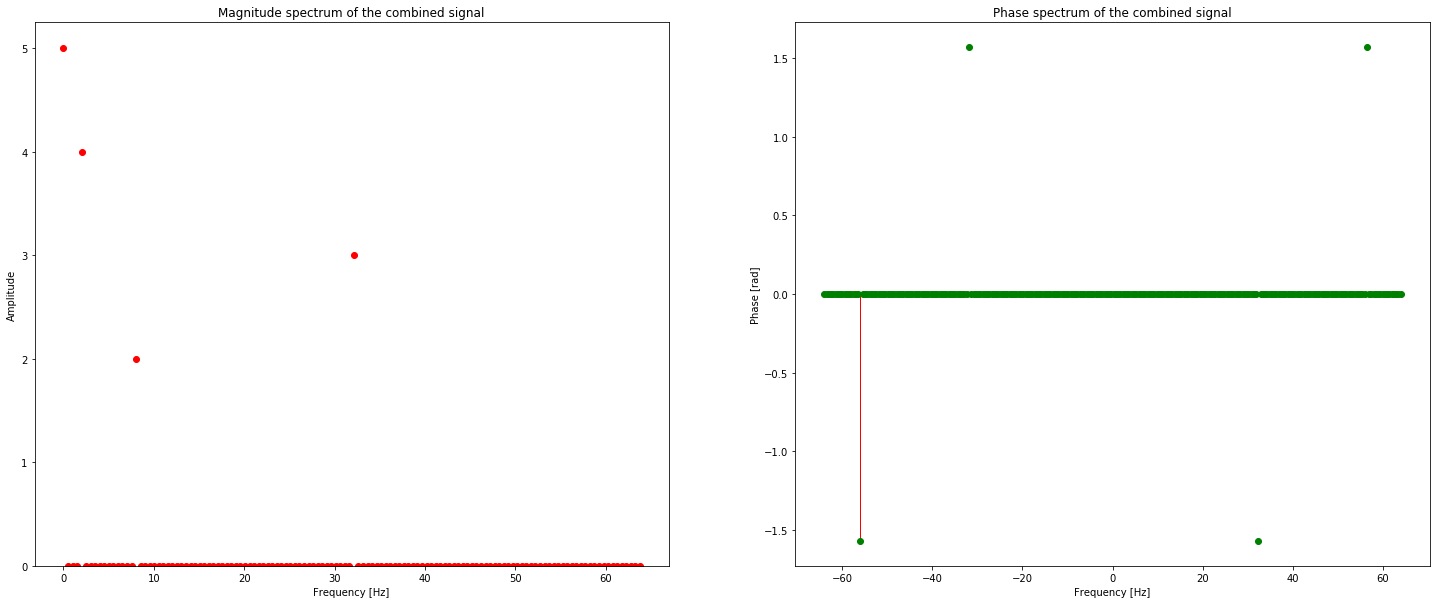

In [13]:
signal1DFFT = FFT(signal1D)
f, axarr = plt.subplots(1, 2, figsize=(25,10))
axarr[0].set_title("Magnitude spectrum of the combined signal")
axarr[1].set_title("Phase spectrum of the combined signal")

# YOUR CODE HERE
#magnitude
dt = T/nsamps
freqm = linspace(0, 1/dt, nsamps)
axarr[0].set_ylabel("Amplitude")
axarr[0].set_xlabel("Frequency [Hz]")
mag = absolute(signal1DFFT)*2
mag[0] = mag[0]/2
axarr[0].bar(freqm[0:nsamps//2],mag[0:nsamps//2]*(1/nsamps), width=dt, color="green")
axarr[0].plot(freqm[0:nsamps//2],mag[0:nsamps//2]*(1/nsamps), "ro")
#phase
freqp = linspace(-1/(2*dt), 1/(2*dt), nsamps)
for i in range (nsamps):
    if(absolute(signal1DFFT[i])<0.1):
        signal1DFFT[i] = 0
axarr[1].set_ylabel("Phase [rad]")
axarr[1].set_xlabel("Frequency [Hz]")
axarr[1].bar(freqp,angle(signal1DFFT), width=dt, color="red")
axarr[1].plot(freqp,angle(signal1DFFT), "go")

plt.show()


# Application: Audio Processing **[45 points]**

In real-world engineering settings, life isn't easy. Data you capture is unreliable -- at best -- having been polluted by countless sources: signal-to-noise issues in your sensors, background corruption of your signal, and even bad luck (!) will haunt the data you hope to draw conclusions from. What's worse is that, often, you may not _know_ of all the ways the data is corrupted, and so you can't even start taking steps towards modeling the actual corruption.

Frequency-domain analysis is one of many tools to help skirt some of these issues.

The example we'll look at next is that of cleaning a corrupted audio sample. To do so, we'll load the audio, compute its frequency spectrum, process the spectrum to remove the corruption, and re-generate (hopefully) clean(er) audio as an output.

Let's load some corrupted audio. Turn your __volume down__ when you listen to it.

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to load and play the noisy audio signal. <i>Volume warning!</i>
</div>

In [14]:
noisyInfo = load('Data/noisyMessage.npz')
noisyMessage = noisyInfo['msg']
sampleRate = int(noisyInfo['rate'])
numSamples = noisyMessage.shape[0]
Audio(data=noisyMessage, rate=sampleRate)

This audio data encodes `numSamples` number of audio amplitude samples, captured at a rate of `sampleRate` Hz. You can verify that `numSamples` is conveniently a power-of-2.

## Visualizing Audio **[5 points]**

Let's plot the data to see what it looks like.

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to visualize the corrupted audio signal.
</div>


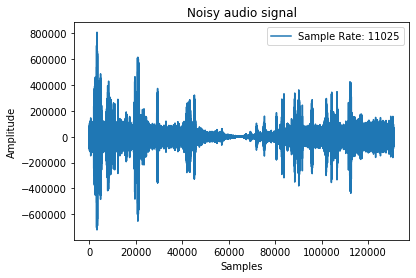

In [15]:
plt.plot(noisyMessage, label='Sample Rate: ' + str(sampleRate))
plt.legend(loc='upper right')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Noisy audio signal')
plt.show()

What a mess! First, complete the code below to add some meaning to the plot by changing the units of the $x$-axis from raw samples to _time_ (measured in seconds).

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[5 Points]</b> Re-plot the audio track, but now with an $x$-axis corresponding to the physical quantity of time, measured in seconds.
</div>

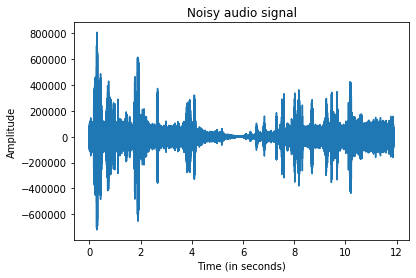

In [16]:
plt.xlabel('Time (in seconds)')
plt.ylabel('Amplitude')
plt.title('Noisy audio signal')

T = noisyMessage.size/11025
scale = linspace(0, T, noisyMessage.size)
plt.plot(scale,noisyMessage)
# YOUR CODE HERE
#raise NotImplementedError()

plt.show()

## Visualizing Audio in the Frequency Domain [15 points]

Maybe you've guessed where we're going with this? At a high-level, we're going to:
1. compute the DFT,
2. visualize the frequency spectrum to gain insight on how we may manipulate the signal (in the frequency domain), 
3. carefully manipulate the spectrum, 
4. use the iDFT to convert our processed spectrum back to a (hopefully cleaner) audio clip.

Let's start by visualizing the magnitude spectrum of our signal.

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[5 Points]</b> Compute the FFT of the audio signal and visualize its magnitude spectrum.
</div>    

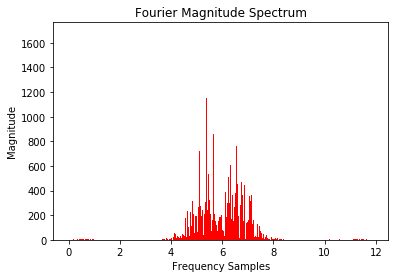

In [17]:
plt.xlabel('Frequency Samples')
plt.ylabel('Magnitude')
plt.title('Fourier Magnitude Spectrum')

# YOUR CODE HERE
audioFFT = FFT(noisyMessage)
plt.bar(scale,absolute(audioFFT)/numSamples,width = 1/sampleRate, color = "red")
#raise NotImplementedError()

plt.show()

The magnitudes have a huge dynamic range. Let's re-plot the $y$-axis on a log scale to see if we're ignoring content across scales.

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[5 Points]</b> Visualize the audio's frequency magnitude spectrum on a log scale. <b><u>Hint</u>:</b> You'll have to lookup the appropriate `matplotlib` function call for this plot.
</div>

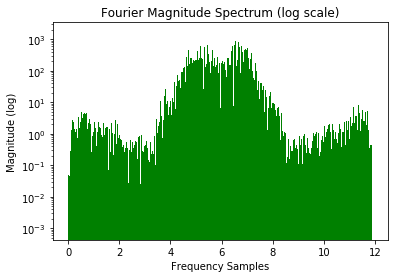

In [18]:
plt.xlabel('Frequency Samples')
plt.ylabel('Magnitude (log)')
plt.title('Fourier Magnitude Spectrum (log scale)')

# YOUR CODE HERE
plt.bar(scale,absolute(audioFFT)/numSamples,width = 1/sampleRate, color = "green")
plt.yscale('log')
#raise NotImplementedError()

plt.show()

Much like in our primal domain plots, the $x$-axis in this last two plots don't correspond to any physical units -- they're simply the sampled indices of the DFT transform. Adjust the $x$-axis units to correspond to _audio frequency_ (measured in Hz.)

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[5 Points]</b> Re-plot the audio track, but now with an $x$-axis corresponding to the physical quantity of 1/time = frequency, measured in Hertz. <b><u>Hint</u>:</b> The maximum frequency content that can be captured is the input <i>sampling rate</i> of the audio.
</div>

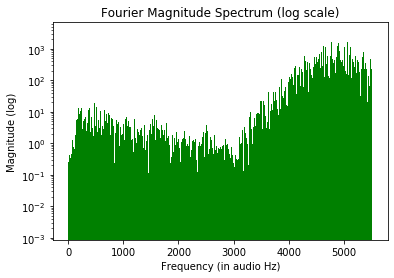

In [19]:
plt.xlabel('Frequency (in audio Hz)')
plt.ylabel('Magnitude (log)')
plt.title('Fourier Magnitude Spectrum (log scale)')

# YOUR CODE HERE

N= noisyMessage.size
newScale = linspace(0, sampleRate, N)
magnitude = absolute(audioFFT)*2
magnitude[0] = magnitude[0]/2
plt.bar(newScale[0:N//2],magnitude[0:N//2]/N, width=1/T, color="green")
plt.yscale('log')

plt.show()

## Filtering Audio in the Frequency Domain [25 points]

Taking a quick look at the log frequency spectrum we plotted, you should notice that there's a sharp increase in higher frequency content at some point along the way.

Let's filter out some of this higher-frequency content. There are many ways to do this that you can experiment with:
- simply zero-out the frequency content you think is polluting the signal,
- scale down the frequency content[^box] you think is polluting the signal, or
 or
- apply a more advanced filter, such as a Gaussian filter**[challenge2]**.

Also, it's important to remember that -- since this input sequence is real-valued -- you should perform your filtering on the first half of the frequency samples, and then appropriately mirror the filtered frequency content to account for the symmetries in the DFT.

[^box]: This corresponds to applying a box filter in the primal domain.

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[25 Points]</b> Design and apply a filter in the frequency domain that cleans the audio clip. You will have to experiment with different strategies, here.
</div>

In [20]:
# inAudioFFT - DFT of the input audio signal
# return a filtered DFT output
def freqSpaceFilter(inAudioFFT : complex):
    processedFFT = inAudioFFT.copy()
    # YOUR CODE HERE
    N = processedFFT.size
    threshold = int(3000*T)
    for i in range(threshold, N-threshold):
        processedFFT[i] = 0
    return processedFFT

noisyMessageFFT = FFT(noisyMessage)

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to applh your `freqSpaceFilter` routine, and to visualize the magnitude spectrum on a log scale.
</div>
    

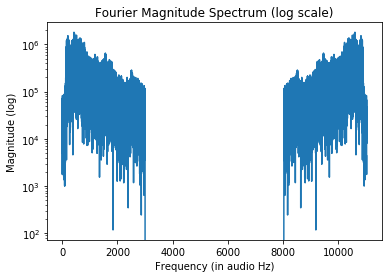

In [21]:
plt.xlabel('Frequency (in audio Hz)')
plt.ylabel('Magnitude (log)')
plt.title('Fourier Magnitude Spectrum (log scale)')

# Optionally uncomment this line if you've changed the original signal's DFT
# noisyMessageFFT = FFT(noisyMessage)

cleanMessageFFT = freqSpaceFilter(noisyMessageFFT)
plt.semilogy(linspace(0, sampleRate, numSamples), absolute(cleanMessageFFT))
plt.show()

If you're satisfied with the spectrum your filter generates, use the following cell to create its associated audio clip.

If you can discern the correct output without needing to "squint your ears" much, then you've completed the task successfully. We will employ a similar "ear metric" when evaluating your audio output.


<div class="alert alert-info" role="alert">
    <b>Run</b> the following cell to create a (hopefully cleaner) audio signal. <i>Watch your volume settings!</i>
</div>

In [22]:
Audio(data=real(iFFT(freqSpaceFilter(noisyMessageFFT))), rate=sampleRate)

**[challenge2]**: Those of you who enjoyed this last bit and want to dig a little deeper: read up on other filters -- and their implementations in the frequency domain -- and try to see how clean you can get the output audio to be. Also, coupled with the earlier suggestion on testing different base cases for the accelerate DFT computation in `FFT`, you can also try to improve the _speed_ of your frequency-domain filtering. Feel free to send the Professor your best results (either in performance, quality, or both) and he'll report them as a benchmark challenge for next year's class. You can do this after the deadline, as any such additional work is not a graded component of this assignment.